In [1]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
from pathlib import Path

#import dolfinx
import ufl
import dolfinx.cpp
import dolfinx.io
from dolfinx import default_scalar_type, plot
from tqdm import tqdm
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import grad, inner, split
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx_mpc import MultiPointConstraint


import pyvista

In [2]:
nex = int(64)
ney = int(32)

PSRI_control = True
plot_control = True

ele_dict = {0 : "tri_P1",
            1 : "tri_P2",
            2 : "tri_P2B3",
            3 : "qua_P1",
            4 : "qua_P2",
            5 : "qua_S2",}

ele_index = 4
ele_type = ele_dict[ele_index]
tol = 250 * np.finfo(default_scalar_type).resolution

if ele_type == "tri_P2B3":
    cell_type = CellType.triangle
    
elif ele_type == "tri_P2":
    cell_type = CellType.triangle

elif ele_type == "tri_P1":
    cell_type = CellType.triangle
    
elif ele_type == "qua_P2":
    cell_type = CellType.quadrilateral
    
elif ele_type == "qua_P1":
    cell_type = CellType.quadrilateral

elif ele_type == "qua_S2":
    cell_type = CellType.quadrilateral
    

if PSRI_control:
    results_folder = Path(f"results/nonlinear-naghdi/PSRI/cylinder-periodic-arclength/{nex}_{ney}_{ele_type}")
else:
    results_folder = Path(f"results/nonlinear-naghdi/FI/cylinder-periodic-arclength/{nex}_{ney}_{ele_type}")

results_folder.mkdir(exist_ok=True, parents=True)

# Initial shape

In [3]:
r = 1.016 
L = 3.048 
E, nu = 2.0685E7, 0.3 
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = 0.03 

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[-np.pi/2, 0], [3*np.pi/2, L]]), 
                        [nex, ney], cell_type)

tdim = mesh.topology.dim
fdim = tdim - 1

cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
if ele_index == 5:
    S2 = element("Serendipity", cell, degree=2)
elif ele_index == 2:
    B3 = element("Bubble", cell, degree=3)
    
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0]), x[1], r * ufl.cos(x[0])])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)

def tangent_1(phi):
    t1 = phi.dx(0)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

t1_ufl = tangent_1(phi0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

if plot_control:
    P1_d3_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))

    n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
    n0_P1_func = Function(P1_d3_FS)
    n0_P1_func.interpolate(n0_P1_expr)

    phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
    phi0_P1_func = Function(P1_d3_FS)
    phi0_P1_func.interpolate(phi0_P1_expr)

    topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

    geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
    geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

    grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
    grid_phi0_P1["n0"] = geometry_n0_P1
    glyphs = grid_phi0_P1.glyph(orient="n0", factor=0.1)


    plotter = pyvista.Plotter(off_screen = True)
    plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
    plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
    plotter.show_grid()
    plotter.show_axes_all()
    plotter.enable_parallel_projection()
    plotter.show()
    plotter.close()

Widget(value='<iframe src="http://localhost:39223/index.html?ui=P_0x7f408b1a8610_0&reconnect=auto" class="pyvi…

# Shell model

In [4]:
if ele_type == "tri_P2B3":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )

elif ele_type == "tri_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
elif ele_type == "qua_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "qua_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )

elif ele_type == "qua_S2":
    naghdi_shell_element = mixed_element(
        [blocked_element(S2, shape=(3,)), blocked_element(S2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = 0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return 0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

if ele_type == "qua_P1" or ele_type == "tri_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    
else:
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})


# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
f = Constant(mesh, default_scalar_type((0.0, 0.0, 0.0, 0.0, 0.0)))
Wext = ufl.inner(f, q_func)*dx_f

Fint = ufl.derivative(Pi_PSRI, q_func, q_test)
Fext = ufl.derivative(Wext, q_func, q_test)

Residual = Fint - Fext
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Boundary Conditions

In [5]:
# Dirichlet boundary conditions
def clamped_boundary(x):
    return np.isclose(x[1], 0.0, atol = tol)

clamped_facets = locate_entities_boundary(mesh, fdim, clamped_boundary)

u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, clamped_facets)
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, clamped_facets)
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

bcs = [bc_clamped_u, bc_clamped_theta]

# Create MPC
def periodic_boundary(x):
    return np.isclose(x[0], 3*np.pi/2, atol=tol)

def periodic_relation(x):
    out_x = np.zeros_like(x)
    out_x[0] = x[0] - 2*np.pi
    out_x[1] = x[1]
    out_x[2] = x[2]
    return out_x

mpc = MultiPointConstraint(naghdi_shell_FS)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(0).sub(0), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(0).sub(1), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(0).sub(2), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(1).sub(0), periodic_boundary, periodic_relation, bcs)
mpc.create_periodic_constraint_geometrical(naghdi_shell_FS.sub(1).sub(1), periodic_boundary, periodic_relation, bcs)
mpc.finalize()

# Check the MPC
num_slaves_global = mesh.comm.allreduce(len(mpc.slaves), op=MPI.SUM)
num_masters_global = mesh.comm.allreduce(len(mpc.masters.array), op=MPI.SUM)

assert num_slaves_global > 0
assert num_masters_global == num_slaves_global

print(f"number of total master dofs: {num_masters_global}")
print(f"number of total slave dofs: {num_slaves_global}")

number of total master dofs: 320
number of total slave dofs: 320


# Point source

In [6]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)
    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmap
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))
        # Strip out basis function values per cell
        basis_values = values[0]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=default_scalar_type)
    return cells, basis_values

if mesh.comm.rank == 0:
    point_A = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
    point_B = np.array([[np.pi, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    point_A = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)
    point_B = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

ps_cell_A, basis_values_A = compute_cell_contributions(mpc.function_space, point_A)
ps_cell_B, basis_values_B = compute_cell_contributions(mpc.function_space, point_B)

ps_cells = [ps_cell_A, ps_cell_B]
ps_basis_values = [basis_values_A, basis_values_B]
ps_dirs = [2, 2]
ps_scales = [1.0, -1.0]

print(f"total cells: {ps_cells}")
print(f"total basis_values: {ps_basis_values}")


total cells: [[976], [1895]]
total basis_values: [array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0.])]


In [7]:
from ArclengthMPCProblem import ArclengthMPCProblem
almpc_problem = ArclengthMPCProblem(
    Fint, Fext, q_func, mpc=mpc, lmbda0= 0.0, bcs=bcs,
    J=Jacobian, petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    ps_cells=ps_cells, ps_basis_values=ps_basis_values,
    ps_dirs=ps_dirs, ps_scales=ps_scales
    )

almpc_problem.max_it = 50
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")

## Newton steps with 2nd order predictions

In [ ]:
nstep = 100

Fc_list = np.zeros(nstep)

q_func.x.array[:] = 0.0

bb_point_A = np.array([[0.0, L, 0.0]], dtype=np.float64)
bb_point_B = np.array([[np.pi, L, 0.0]], dtype=np.float64)

almpc_problem.reset()
if mesh.comm.rank == 0:
    u3_list_A = np.zeros(nstep)
    u3_list_B = np.zeros(nstep)

i = 0
ds_max = 0.0
pbar = tqdm(total=nstep)

while i < nstep:
    if i < 3:
        Pred = False
        Fc = -50 * i
    else:
        Pred = True
        Fc = -50 * i
    
    n, converged = almpc_problem.NewtonStep(Pred_control = Pred, lmbda2 = Fc)
        
    if converged:
        q_func.x.scatter_forward()
        Fc = almpc_problem.lmbda
        Fc_list[i] = Fc
        
        if not Pred:
            ds_max = max(almpc_problem.ds, ds_max)
        # write output
        if ele_type == "qua_P1" or ele_type == "tri_P1":
            phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
        else:
            phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
            
        if ele_type == "tri_P2B3":
            u_P2B3 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_P2B3)
            theta_sol = q_func.sub(1).collapse()
        elif ele_type == "qua_S2":
            u_S2 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_S2)
            
            theta_S2 = q_func.sub(1).collapse()
            theta_FS = functionspace(mesh, blocked_element(P2, shape=(2,)))
            theta_sol = Function(theta_FS)
            theta_sol.interpolate(theta_S2)
            
        else:
            u_sol = q_func.sub(0).collapse()
            theta_sol = q_func.sub(1).collapse()
        
        phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
        phi_sol = Function(phi_FS)
        phi_sol.interpolate(phi_expr)
        
        file_u.write_function(u_sol, i)
        file_theta.write_function(theta_sol, i)
        file_phi.write_function(phi_sol, i)
        
        # calculate u3 at the point load
        u3_bb_A = 0.0
        u3_bb_B = 0.0
        u3_func = q_func.sub(0).sub(2).collapse()

        if len(ps_cell_A) > 0:
            u3_bb_A = u3_func.eval(bb_point_A, ps_cell_A[0])[0]
        u3_bb_A = mesh.comm.allreduce(u3_bb_A, op=MPI.SUM)
        
        if len(ps_cell_B) > 0:
            u3_bb_B = u3_func.eval(bb_point_B, ps_cell_B[0])[0]
        u3_bb_B = mesh.comm.allreduce(u3_bb_B, op=MPI.SUM)
        
        if mesh.comm.rank == 0:
            u3_list_A[i] = u3_bb_A
            u3_list_B[i] = u3_bb_B
            print(f"Load step {i:d}, Number of iterations: {n:d}, " 
                f"Load: {Fc:.2f}, Disp: {u3_bb_A:.2f}, "
                f"ds: {almpc_problem.ds:.2f}, s: {almpc_problem.s:.2f}", flush=True)
            
        # adaptive step size control
        if n < 5:
            almpc_problem.ds = min(1.2*almpc_problem.ds, ds_max)
        if n > 8:
            almpc_problem.ds *= 0.8
            
        if Fc_list[i] < - 2000.0:
            break
        
        i += 1
        pbar.update(1)
    else:
        almpc_problem.ds *= 0.5

   
file_u.close()
file_theta.close()
file_phi.close()
pbar.close()

## Arc length step

In [ ]:
nstep = 100

Fc_list = np.zeros(nstep)

q_func.x.array[:] = 0.0

bb_point_A = np.array([[0.0, L, 0.0]], dtype=np.float64)
bb_point_B = np.array([[np.pi, L, 0.0]], dtype=np.float64)

almpc_problem.reset()
if mesh.comm.rank == 0:
    u3_list_A = np.zeros(nstep)
    u3_list_B = np.zeros(nstep)

i = 0
ds_max = 0.0
pbar = tqdm(total=nstep)

while i < nstep:
    if i < 3:
        Pred = False
        Fc = -50 * i
        n, converged = almpc_problem.NewtonStep(Pred_control = Pred, lmbda2 = Fc)
    else:
        n, converged = almpc_problem.ArclengthStep()
    
        
    if converged:
        q_func.x.scatter_forward()
        Fc = almpc_problem.lmbda
        Fc_list[i] = Fc
        
        if not Pred:
            ds_max = max(almpc_problem.ds, ds_max)
        # write output
        if ele_type == "qua_P1" or ele_type == "tri_P1":
            phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
        else:
            phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
            
        if ele_type == "tri_P2B3":
            u_P2B3 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_P2B3)
            theta_sol = q_func.sub(1).collapse()
        elif ele_type == "qua_S2":
            u_S2 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_S2)
            
            theta_S2 = q_func.sub(1).collapse()
            theta_FS = functionspace(mesh, blocked_element(P2, shape=(2,)))
            theta_sol = Function(theta_FS)
            theta_sol.interpolate(theta_S2)
            
        else:
            u_sol = q_func.sub(0).collapse()
            theta_sol = q_func.sub(1).collapse()
        
        phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
        phi_sol = Function(phi_FS)
        phi_sol.interpolate(phi_expr)
        
        file_u.write_function(u_sol, i)
        file_theta.write_function(theta_sol, i)
        file_phi.write_function(phi_sol, i)
        
        # calculate u3 at the point load
        u3_bb_A = 0.0
        u3_bb_B = 0.0
        u3_func = q_func.sub(0).sub(2).collapse()

        if len(ps_cell_A) > 0:
            u3_bb_A = u3_func.eval(bb_point_A, ps_cell_A[0])[0]
        u3_bb_A = mesh.comm.allreduce(u3_bb_A, op=MPI.SUM)
        
        if len(ps_cell_B) > 0:
            u3_bb_B = u3_func.eval(bb_point_B, ps_cell_B[0])[0]
        u3_bb_B = mesh.comm.allreduce(u3_bb_B, op=MPI.SUM)
        
        if mesh.comm.rank == 0:
            u3_list_A[i] = u3_bb_A
            u3_list_B[i] = u3_bb_B
            print(f"Load step {i:d}, Number of iterations: {n:d}, " 
                f"Load: {Fc:.2f}, Disp: {u3_bb_A:.2f}, "
                f"ds: {almpc_problem.ds:.2f}, s: {almpc_problem.s:.2f}", flush=True)
            
        # adaptive step size control
        if n < 5:
            almpc_problem.ds = min(1.2*almpc_problem.ds, ds_max)
        if n > 8:
            almpc_problem.ds *= 0.8
            
        if Fc_list[i] < - 2000.0:
            break
        
        i += 1
        pbar.update(1)
    else:
        almpc_problem.ds *= 0.5

   
file_u.close()
file_theta.close()
file_phi.close()
pbar.close()

# Post-processing

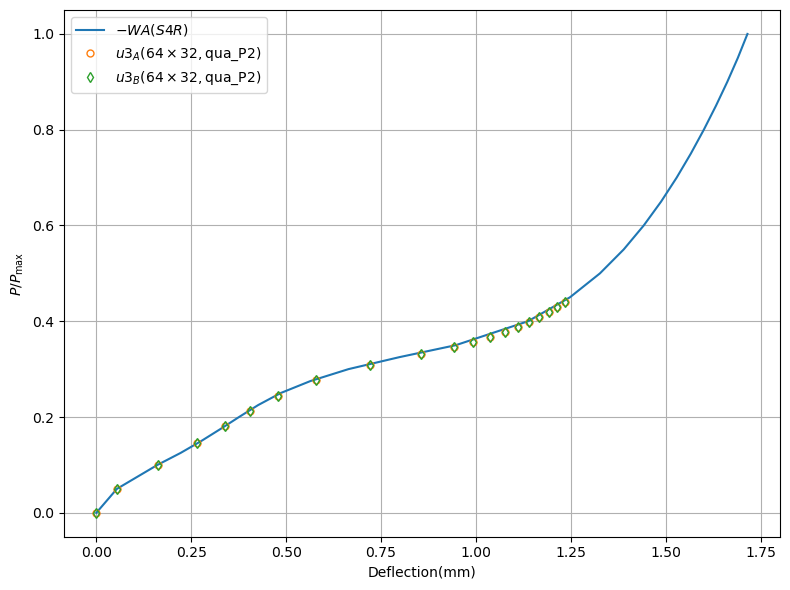

In [13]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    WA_S4R = 1.e-2*np.array([0., 5.421, 16.1, 22.195, 27.657, 32.7, 37.582, 42.633,
        48.537, 56.355, 66.410, 79.810, 94.669, 113.704, 124.751, 132.653,
        138.920, 144.185, 148.770, 152.863, 156.584, 160.015, 163.211,
        166.200, 168.973, 171.505])
        
    P_S4R = np.array([0., .05, .1, .125, .15, .175, .2, .225, .25, .275, .3,
        .325, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.])
    
    u3_list_A = u3_list_A[:i+1]
    u3_list_B = u3_list_B[:i+1]
    Fc_list = Fc_list[:i+1]
    Fc_max = -2000.0
    np.savetxt(results_folder/"u3_list_A.txt", u3_list_A)
    np.savetxt(results_folder/"u3_list_B.txt", u3_list_B)
    np.savetxt(results_folder/"Fc_list.txt", Fc_list)
    
    plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$-WA(S4R)$")
    plt.plot(-u3_list_A, Fc_list / Fc_max, "o", markersize=5, markerfacecolor='none',
             markevery = 2, label=f"$u3_A({nex}\\times{ney},${ele_type})")
    plt.plot(u3_list_B, Fc_list / Fc_max, "d", markersize=5, markerfacecolor='none',
             markevery = 2, label=f"$u3_B({nex}\\times{ney},${ele_type})")
    plt.xlabel("Deflection(mm)")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png", dpi=300)

In [11]:
topology, cell_types, geometry = plot.vtk_mesh(phi_FS)
geometry_phi = phi_sol.x.array.reshape((geometry.shape[0], len(phi_sol)))
grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
plotter.show()
plotter.close()

Widget(value='<iframe src="http://localhost:39223/index.html?ui=P_0x7f408b04b750_0&reconnect=auto" class="pyvi…